# Artificial Intelligence Application: Inventory Simulation

The goal of this notebook is to create an intelligent agent which automatically conducts the product-re-orders in an inventory simulation. The intelligent agent consists of a forecasting model and an order policy which decides how many products shall be ordered based on the current stock on hand, the already oredered products of the last periods, the actual demand of the current period and the forecast of the future lead-time-demands.

The time series is taken from the NN3-Competition (http://www.neural-forecasting-competition.com/NN3/) and the inventory simulation is adapted from the book Vandeput, N. (2020). Inventory optimization: Models and simulations. de Gruyter Berlin/Boston. However, the inventory policy is changed, so that the forecasts are included into the process, while the original application did not consider forecasts.

## Load data 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

In [3]:
y = [7433, 
7694, 
8526, 
7539, 
7428, 
7835, 
6147, 
7418, 
7764, 
7691, 
6793, 
6986, 
7749, 
7496, 
7685, 
8163, 
7827, 
7737, 
6285, 
8220, 
8180, 
8367, 
7568, 
7742, 
8375, 
8749, 
9561, 
8494, 
9022, 
9279, 
7773, 
9039, 
8667, 
9568, 
8323, 
7841, 
9191, 
8688, 
9352, 
8694, 
8391, 
7608, 
6495, 
8318, 
8422, 
8813, 
7599, 
6893, 
8153, 
7983, 
8484, 
8019, 
7502,
7324, 
7102, 
8056,
8270, 
9090, 
7572, 
7592, 
8440, 
8297, 
8867, 
8340, 
8491, 
8274, 
7898, 
8362, 
8602, 
9478, 
8228, 
8214, 
8673, 
9014, 
9653, 
8821, 
8702, 
8971, 
7511, 
9029, 
9058, 
9569, 
8627, 
8051, 
9472, 
9051, 
9835, 
9612, 
9545, 
9156, 
7418, 
9144, 
8482, 
9200, 
8162, 
7361, 
9509, 
8688, 
9761, 
8840, 
8995, 
9093, 
7498, 
9278, 
8806, 
9983, 
8039, 
6844, 
8857, 
8688, 
8104, 
8509, 
8680, 
8210, 
7177, 
8892, 
8523, 
9794, 
8177, 
7587, 
9386, 
9381, 
10178, 
9533, 
9437, 
9690, 
8637, 
10153, 
9988, 
10801, 
9192, 
8751, 
10019, 
9936, 
10950, 
10232, 
10174, 
9971, 
8728, 
10494, 
10043, 
10458, 
9207, 
8515,]

index = pd.date_range(start="2000", end="2012", freq="M")
data = pd.Series(y, index)
demand = pd.DataFrame({'data':data.values}).set_index(data.index)

In [4]:
# Division into training and test set
n_test=12
n_train=len(demand)-n_test
demand_train = demand[:n_train]
demand_test  = demand[n_train:]

In [5]:
print('n_train=',n_train)
print('n_test=',n_test)

n_train= 132
n_test= 12


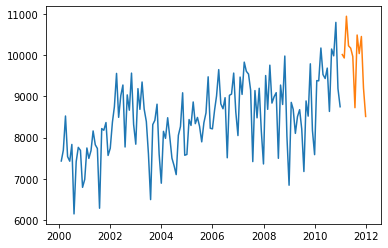

In [6]:
import matplotlib.pyplot as plt
plt.plot(demand_train,label='train')
plt.plot(demand_test,label='test')

## Compare different forecasting methods for this dataset 

C:\Users\Mirko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


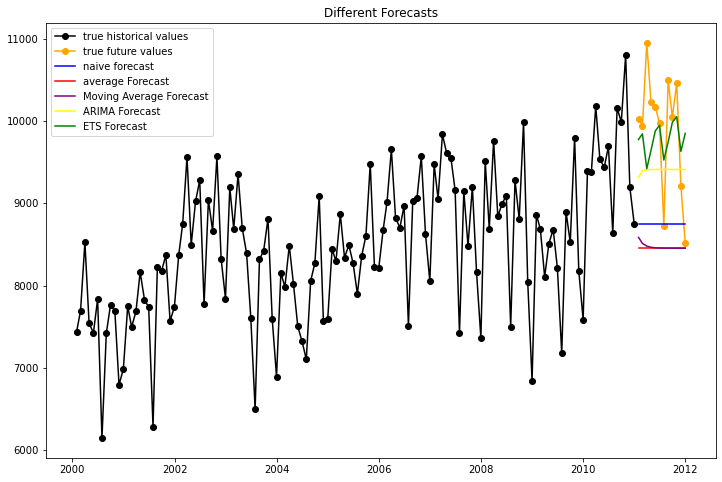

In [7]:
# naive forecasts
y_hat_naive = demand_test.copy()
y_hat_naive['data'] = np.repeat(demand_train.values[n_train-1],n_test)

# average forecasts
y_hat_avg = demand_test.copy()
y_hat_avg['data'] = np.repeat(demand_train.values.mean(),n_test)

# moving average forecasts
y_hat_ma = demand_test.copy()
model = ARIMA(demand_train, order=(1, 0, 0))
model_fit = model.fit()
y_hat_ma = model_fit.forecast(n_test)

# ARIMA forecasts
model = ARIMA(demand_train, order=(1,1,1))
model_fit = model.fit()
y_hat_arima = model_fit.forecast(n_test)

# Holt-Winters Seasonal exponential with additive trend 
model = ExponentialSmoothing(
    demand_train,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
y_hat_ets = model.forecast(n_test)


# plots
plt.figure(figsize=(12, 8))
plt.plot(demand_train, marker="o", color="black",label='true historical values')
plt.plot(demand_test, marker="o", color="orange",label='true future values')
plt.plot(y_hat_naive, color="blue",label='naive forecast')
plt.plot(y_hat_avg, color='red', label='average Forecast')
plt.plot(y_hat_ma, color='purple', label='Moving Average Forecast')
plt.plot(y_hat_arima, color='yellow', label='ARIMA Forecast')
plt.plot(y_hat_ets, color='green', label='ETS Forecast')

plt.title("Different Forecasts")
plt.legend()

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print('RMSE_naive=',sqrt(mean_squared_error(demand_test, y_hat_naive)))
print('RMSE_avg=',sqrt(mean_squared_error(demand_test, y_hat_avg)))
print('RMSE_ma=',sqrt(mean_squared_error(demand_test, y_hat_ma)))
print('RMSE_arima=',sqrt(mean_squared_error(demand_test, y_hat_arima)))
print('RMSE_ets=',sqrt(mean_squared_error(demand_test, y_hat_ets)))

RMSE_naive= 1336.6520053227516
RMSE_avg= 1598.6296515628107
RMSE_ma= 1578.7820797992026
RMSE_arima= 852.7060147612202
RMSE_ets= 717.4753526537085


## Artificial Intelligence Application: Intelligent Agent consisting of forecasting model combined with re-order-policy

The division of the demand time series into training and test set is changed.

In [8]:
n_test=48
n_train=len(demand)-n_test
demand_train = demand[:n_train]
demand_test  = demand[n_train:]

In [9]:
print('n_train=',n_train)
print('n_test=',n_test)

n_train= 96
n_test= 48


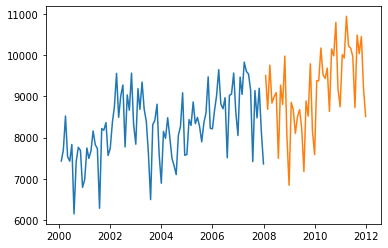

In [10]:
plt.plot(demand_train,label='train')
plt.plot(demand_test,label='test')

In [11]:
import numpy as np
import pandas as pd
np.random.seed(0)
time = len(demand_test)
d_mu = pd.to_numeric(demand_train.mean().round(0),downcast='integer')
d_std = demand_train.std()

In [12]:
d_mu

data    8273
dtype: int16

In [13]:
d_std

data    793.074991
dtype: float64

In [15]:
# Lead-time L, review interval R, target service level alpha
from scipy.stats import norm
L, R, alpha = 2, 1, 0.95 
z = norm.ppf(alpha) 
x_std = np.sqrt(L+R)*d_std

In [16]:
z

1.6448536269514722

In [17]:
x_std

data    1373.646179
dtype: float64

In [18]:
#Safety stock. Since the dataset does not follow a normal distribution, the safety stock of a normal distribution is not enough.
# Here, we multiply the value with 5. Another possibility which is currently applied in research, is kernel density estimation.
# This should be considered in a real application. However, here we stick with the normal distribution for simplicity.
Ss = np.round(5*x_std*z).astype(int)
print('Safety Stock Ss=',Ss)

Safety Stock Ss= data    11297
dtype: int32


### Initial values for the simulation

In [19]:
# lead-time forecasts
forecasts = np.zeros((time,L+1), dtype=int)
# dynamic order-up-to level
S = np.zeros(time, dtype=int) 
# inventory on hand
hand = np.zeros(time, dtype=int) 
# work-in-process = inventory in-transit
#transit = np.full((time,L+1), pd.to_numeric(d_mu.round(0),downcast='integer'))
transit = np.full((time,L+1),d_mu)
#
stockout_period = np.full(time, False, dtype=bool)
stockout_cycle = []

In [20]:
S[0] = Ss
hand[0] = S[0] - y[n_train]
transit[1,-1] = y[n_train]

In [21]:
for t in range(1,time): 
  if transit[t-1,0]>0: 
    stockout_cycle.append(stockout_period[t-1]) 
  hand[t] = hand[t-1] - y[n_train+t] + transit[t-1,0] 
  stockout_period[t] = hand[t] < 0
  #hand[t] = max(0,hand[t]) #Uncomment if excess demand result in lost sales rather than backorders
  transit[t,:-1] = transit[t-1,1:]
  if 0==t%R: 
    net = hand[t] + transit[t].sum()
    # fit exponential smoothing model and forecast one L=2 values into the future
    model = ExponentialSmoothing(
        demand[:n_train+t],
        seasonal_periods=4,
        trend="add",
        seasonal="add",
        use_boxcox=True,
        initialization_method="estimated",
    ).fit()
    forecasts[t] = model.forecast(L+1).values
    S[t] = Ss + forecasts[t].sum()
    transit[t,L] = np.maximum(S[t] - net,0)

C:\Users\Mirko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Mirko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Mirko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Mirko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Mirko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Mirko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

In [22]:
df = pd.DataFrame(data= {'Demand':demand_test.values.reshape(48,), 'On−hand':hand, 'In−transit':list(transit)}) 
print(df)

    Demand  On−hand             In−transit
0     9509     1788     [8273, 8273, 8273]
1     8688     1373     [8273, 8273, 9757]
2     9761     -115    [8273, 9757, 10824]
3     8840     -682   [9757, 10824, 10546]
4     8995       80   [10824, 10546, 8746]
5     9093     1811    [10546, 8746, 8773]
6     7498     4859     [8746, 8773, 7461]
7     9278     4327     [8773, 7461, 8572]
8     8806     4294     [7461, 8572, 9362]
9     9983     1772     [8572, 9362, 9672]
10    8039     2305     [9362, 9672, 8857]
11    6844     4823     [9672, 8857, 6622]
12    8857     5638     [8857, 6622, 7240]
13    8688     5807     [6622, 7240, 8710]
14    8104     4325     [7240, 8710, 8064]
15    8509     3056     [8710, 8064, 8753]
16    8680     3086     [8064, 8753, 8593]
17    8210     2940     [8753, 8593, 8051]
18    7177     4516     [8593, 8051, 6752]
19    8892     4217     [8051, 6752, 8547]
20    8523     3745     [6752, 8547, 8999]
21    9794      703     [8547, 8999, 9612]
22    8177 

In [23]:
print('Alpha:',alpha*100)
SL_alpha = 1-sum(stockout_cycle)/len(stockout_cycle)
print('Cycle Service Level:', round(SL_alpha*100,1))
SL_period = 1-sum(stockout_period)/time
print('Period Service Level:', round(SL_period*100,1))

Alpha: 95.0
Cycle Service Level: 91.5
Period Service Level: 91.7


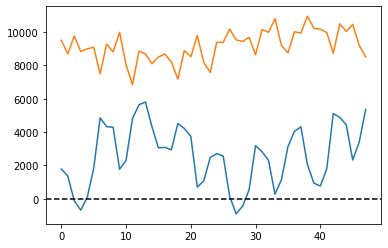

In [24]:
plt.plot(hand)
plt.plot(demand_test.values)
plt.axhline(y=0, color='black', linestyle='--')
